# **TimeCitedFiveYearCNT prediction :**

Some basic setup :

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# importing alll the necessary packages to use the various classification algorithms
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb


Input data :

In [441]:
train_data = pd.read_csv('./5basic_1distance_4681company/data/train_data_distance2_with_CVAE.csv')
test_data = pd.read_csv('./5basic_1distance_4681company/data/test_data_distance2_with_CVAE.csv')

In [442]:
train_data.columns

Index(['PatentNumber', 'TimeCitedFiveYearCNT', 'ForeignRefCNT', 'ReferenceCNT',
       'NPRCNT', 'ClaimCNT', 'CPCCNT', 'InvCtry_Generality_5Y', 'embedd_CVAE'],
      dtype='object')

In [443]:
train_data.head(5)

,PatentNumber,TimeCitedFiveYearCNT,ForeignRefCNT,ReferenceCNT,NPRCNT,ClaimCNT,CPCCNT,InvCtry_Generality_5Y,embedd_CVAE
0,6020086,3.0,3.0,9.0,0.0,10,5.0,0.375000,0.054269
1,6020136,0.0,0.0,0.0,17.0,1,3.0,0.000000,0.045799
2,6020250,8.0,0.0,4.0,0.0,3,9.0,0.518519,0.082125
3,6012550,2.0,0.0,9.0,0.0,6,3.0,0.000000,0.032267
4,6010537,7.0,4.0,2.0,0.0,22,2.0,0.000000,0.034544


TimeCitedFiveYearCNT：

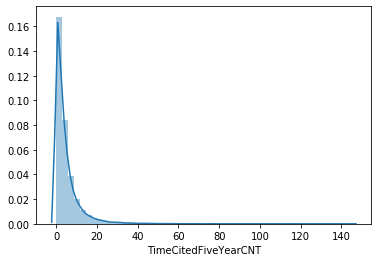

In [444]:
sns.distplot(train_data['TimeCitedFiveYearCNT']);

Apply **Log transfomation** to TimeCitedFiveYearCNT:

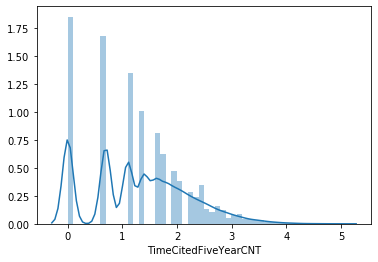

In [445]:
train_data['TimeCitedFiveYearCNT'] = np.log1p(train_data['TimeCitedFiveYearCNT'])
sns.distplot(train_data['TimeCitedFiveYearCNT']);

Now let's concat train data and test data, and save a copy of TimeCitedFiveYearCNT and PatentNumber :

In [446]:
# data preprocessing
PatentNumber = test_data['PatentNumber']
train_y = train_data.TimeCitedFiveYearCNT.values
#print(train_y)
all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
all_data.drop(['TimeCitedFiveYearCNT'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
all_data.head(5)

all_data size is : (89153, 8)


,PatentNumber,ForeignRefCNT,ReferenceCNT,NPRCNT,ClaimCNT,CPCCNT,InvCtry_Generality_5Y,embedd_CVAE
0,6020086,3.0,9.0,0.0,10,5.0,0.375000,0.054269
1,6020136,0.0,0.0,17.0,1,3.0,0.000000,0.045799
2,6020250,0.0,4.0,0.0,3,9.0,0.518519,0.082125
3,6012550,0.0,9.0,0.0,6,3.0,0.000000,0.032267
4,6010537,4.0,2.0,0.0,22,2.0,0.000000,0.034544


**Handling missing value :**

1. drop columns that missing percent is too high or unnecessary :

In [447]:
# drop PatentNumber
all_data = all_data.drop('PatentNumber', axis=1)

# drop NAN that missing ratio is above a certain threshold
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
# print(missing_ratio)
all_data = all_data.drop(missing_ratio[missing_ratio.values > 20].index, axis=1)
# all_data = all_data.drop(missing_data[missing_data.iloc[:] > 0].index, axis=1)
all_data.head(5)

,ForeignRefCNT,ReferenceCNT,NPRCNT,ClaimCNT,CPCCNT,InvCtry_Generality_5Y,embedd_CVAE
0,3.0,9.0,0.0,10,5.0,0.375000,0.054269
1,0.0,0.0,17.0,1,3.0,0.000000,0.045799
2,0.0,4.0,0.0,3,9.0,0.518519,0.082125
3,0.0,9.0,0.0,6,3.0,0.000000,0.032267
4,4.0,2.0,0.0,22,2.0,0.000000,0.034544


2. deal with the rest of the missing value :

In [448]:
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
print(missing_ratio)
all_data[missing_ratio.index].head(5)

Series([], dtype: float64)


""
0
1
2
3
4


In [449]:
all_data = pd.get_dummies(all_data)
all_data.head(5)

,ForeignRefCNT,ReferenceCNT,NPRCNT,ClaimCNT,CPCCNT,InvCtry_Generality_5Y,embedd_CVAE
0,3.0,9.0,0.0,10,5.0,0.375000,0.054269
1,0.0,0.0,17.0,1,3.0,0.000000,0.045799
2,0.0,4.0,0.0,3,9.0,0.518519,0.082125
3,0.0,9.0,0.0,6,3.0,0.000000,0.032267
4,4.0,2.0,0.0,22,2.0,0.000000,0.034544


In [450]:
all_data.columns

Index(['ForeignRefCNT', 'ReferenceCNT', 'NPRCNT', 'ClaimCNT', 'CPCCNT',
       'InvCtry_Generality_5Y', 'embedd_CVAE'],
      dtype='object')

**Split to train and test data :**

In [451]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
# train, test = train_test_split(all_data, test_size=0.4998)
train = all_data[:ntrain]
test = all_data[ntrain:]
train_x = train
print(train_x.shape[0], train_y.shape[0])
# train_y
test_y = test_data.TimeCitedFiveYearCNT.values

70000 70000


**Cross validation :**

In [452]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    print('computing rmse....')
    rmse= np.sqrt(-cross_val_score(model, train.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## **<font color='green'>Select an algorithm :</font>**

lightGBM:

In [408]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

computing rmse....
LGBM score: 0.5742 (0.0067)



xgboost:

In [354]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

score = rmsle_cv(xgb_model)
print("XGBoost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

computing rmse....
XGBoost score: 0.5690 (0.0066)



linear regression:

In [356]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

score = rmsle_cv(lr_model)
print("LinearRegression  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

computing rmse....
LinearRegression  score: 0.7365 (0.0076)



Ridge:

In [357]:
from sklearn.linear_model import (Ridge)

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True, alpha=0.1, fit_intercept=True, solver='sparse_cg') 
#paramters tuned using GridSearchCV

score = rmsle_cv(ridge)
print("ridge  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

computing rmse....
ridge  score: 0.7378 (0.0073)



decision tree:

In [359]:
from sklearn.tree import DecisionTreeRegressor
dtr= DecisionTreeRegressor()

score = rmsle_cv(dtr)
print("DecisionTreeRegressor  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

computing rmse....
DecisionTreeRegressor  score: 0.7575 (0.0080)



GradientBoostingRegressor(GBR):

In [361]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor()

score = rmsle_cv(GBR)
print("GBR  score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

computing rmse....
GBR  score: 0.5694 (0.0061)



# **Mean square error validation :**

In [362]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

result_root = './5basic_4distance_4681company/result/result_CVAE/'

## **<font color='green'>Train the selected model :</font>**

lightGBM:

In [409]:
model.fit(train_x, train_y)
train_prediction = model.predict(train)
prediction = np.expm1(model.predict(test.values))
print(rmsle(train_y, train_prediction))
print(rmsle(test_y, prediction))

0.5687976472684584
5.070223522055462


(lightGBM) Done. Submit the answer.:

In [364]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv(result_root+'lightGBM_submission.csv', index=False)

xgboost:

In [365]:
xgb_model.fit(train_x,train_y)
train_prediction = xgb_model.predict(train)
prediction = np.expm1(xgb_model.predict(test))
#這邊values會出錯，把values去除
# prediction = np.expm1(xgb_model.predict(test.values))
print(rmsle(train_y, train_prediction))
print(rmsle(test_y, prediction))

0.5669878655546666
5.054783857745554


(xgboost) Done. Submit the answer.:

In [366]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv(result_root+'xgboost_submission.csv', index=False)

linear regression:

In [369]:
lr_model.fit(train_x, train_y)

train_prediction = lr_model.predict(train)
prediction = np.expm1(lr_model.predict(test.values))
print(rmsle(train_y, train_prediction))
print(rmsle(test_y, prediction))

0.7362646524834596
11.44811462961189


(linear regression) Done. Submit the answer.:

In [370]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv(result_root+'linear_regression_submission.csv', index=False)

Ridge:

In [371]:
ridge.fit(train_x, train_y)

train_prediction = ridge.predict(train)
prediction = np.expm1(ridge.predict(test.values))
print(rmsle(train_y, train_prediction))
print(rmsle(test_y, prediction))

0.7376400662412457
9.285082145254714


(Ridge) Done. Submit the answer.:

In [372]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv(result_root+'ridge_submission.csv', index=False)

decision tree:

In [375]:
dtr.fit(train_x, train_y)

train_prediction = dtr.predict(train)
prediction = np.expm1(dtr.predict(test.values))
print(rmsle(train_y, train_prediction))
print(rmsle(test_y, prediction))

0.02520332616898706
5.395230697513407


(decision tree) Done. Submit the answer.:

In [376]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv(result_root+'decision_tree_submission.csv', index=False)

GradientBoostingRegressor(GBR):

In [379]:
GBR.fit(train_x, train_y)

train_prediction = GBR.predict(train)
prediction = np.expm1(GBR.predict(test.values))
print(rmsle(train_y, train_prediction))
print(rmsle(test_y, prediction))

0.5676810627921351
5.066073863877825


(GBR) Done. Submit the answer.:

In [380]:
submission = pd.DataFrame({'PatentNumber': PatentNumber, 'TimeCitedFiveYearCNT': prediction})
submission.to_csv(result_root+'GBR_submission.csv', index=False)

## Compare to patent(AAAI 2017)

In [453]:
test_y

array([6., 1., 0., ..., 3., 2., 2.])

In [458]:
patent = pd.read_csv('./patent-master/patent_pred_result4_InvCtry.csv')
patent = patent.values[70000:,1:].squeeze()
patent

array([1.59747315, 2.82504614, 2.26986942, ..., 1.56506861, 1.92818637,
       2.26836112])

In [459]:
print(rmsle(test_y, patent))

7.533090614775396


## Compute ACC and MAPE

In [ ]:
#patent_pred = pd.read_csv('patent_pred.csv')
patent_pred = pd.read_csv('./../5basic_4681company/result/result/GBR_submission.csv')
#patent_pred = patent_pred['Predict']
patent_pred = patent_pred['TimeCitedFiveYearCNT']

target = pd.read_csv('./../dataset_year_2013.csv')
target = target.fillna(0)
target = target['TimeCitedFiveYearCNT']

## ACC-5

In [ ]:
cnt = 0
for i in range(len(patent_pred)):
    error_rate = (patent_pred[i] - target[i+70000])/(target[i+70000]+0.001)
    if error_rate > 0.05:
        cnt += 1
        
1 - cnt/(len(patent_pred))

## ACC-30

In [ ]:
cnt = 0
for i in range(len(patent_pred)):
    error_rate = (patent_pred[] - target[i+70000])/(target[i+70000]+0.001)
    if error_rate > 0.3:
        cnt += 1
        
1 - cnt/(len(patent_pred))

## MAPE

In [ ]:
sum(abs((np.array(target[70000:]) - np.array(patent_pred))/np.array(target[70000:]+0.001)))*100/(len(patent_pred))